# Mentoria de  Detección de Fraude de Tarjeta de Crédito  
## Trabajo: Aprendizaje  no supervisado.

Para el siguiente práctico vamos a suponer la siguiente situación hipotética: nuestros clientes, representados por el área de negocio de la empresa, están interesados en contar con un producto que además de poder detectar fraude en tiempo real, también pueda ayudarles a inferirlo a partir de pagos sobre los cuales no existen todavía etiquetas (es decir, no tenemos confirmación de que sean o no fraudes).
Así que, en orden de obtener este producto y ofrecerlo, deben ponerse manos a la obra con la información que les dieron de los pagos que conocemos (es decir, el que venimos trabajando en los tres últimos prácticos)
El objetivo es estudiar la viabilidad de dicho producto dada la información que podemos utilizar para estudiarlo (en este caso, los componentes del PCA). 

La idea es que vamos a usar al menos dos técnicas de aprendizaje no supervisado que se especializan en el encontrar **anomalías**. Hipotéticamente hablando,  esa anomalía debería ser considerada por defecto candidato a un pago fraudulento. 

Para consultar sobre las técnicas que pueden utilizar y cómo armar el código para nuestro caso particular, dejamos el siguiente recurso:

[Artículo: Fraud Detection applying Unsupervised Learning techniques](https://medium.com/southworks/fraud-detection-applying-unsupervised-learning-techniques-4ae6f71b266f)

[Repo con el notebook](https://github.com/southworks/machine-learning-unsupervised/blob/main/anomaly-detection/fraud_detection.ipynb)

1. Preparamos los datos para comenzar el entrenamiento del modelo. La particularidad aquí es que no vamos a utilizar la etiqueta en la etapa de entrenamiento, si no que la recuperaremos en la estapa de evaluación y medición de performance. Dicho de otra forma, los datos serán analizados de forma agnóstica al target. Para esto debemos considerar la cantidad de registros en el train y en el test. 



2. Ahora vamos a elegir dos tipos de modelos entre los siguientes: Isolation Forest, LOF Novelty Detection y Gaussian Mixture. Como en el práctico anterior, la idea es aproximarnos a la resolución del problema teniendo en cuenta una variedad de estrategias para solucionarlo. 
- Entrenar ambos modelos con los datasets.
- Comparar los modelos entrenados con la instancia de test usando marcando falsos positivos y negativos; verdaderos positivos y verdaderos negativos; y precission y recall y F1.
- ¿Qué modelo dio mejor resultado? ¿Hay una mejoría en general con el dataset balanceado? Graficar si es posible los resultados y desarrollar una respuesta.

# Presentación : Equipo de trabajo <a class="anchor" id="presentacion"></a>


Integrantes:

* Baulina,David

* Carabajal,Javier

* Folonier,Hugo

* Tula,Melani

# 1.-Inicialización del entorno

In [ ]:
import io
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, mean_squared_error, recall_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans,MeanShift,DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from google.colab import files

import warnings
warnings.filterwarnings('ignore')


# 2.-Preparación de datos

In [ ]:
df_1 = pd.read_csv('https://raw.githubusercontent.com/p-eleuterio/card-fraud-detection-2022/main/dataset/fraud_data_pt1.csv', index_col=0)
df_2 = pd.read_csv('https://raw.githubusercontent.com/p-eleuterio/card-fraud-detection-2022/main/dataset/fraud_data_pt2.csv', index_col=0)
df_unidos=pd.concat([df_1,df_2], ignore_index=True)

In [ ]:
def acc_hour_1(df):
    df_time = df.Time.to_numpy()
    df_filtered = df[['Time', 'Class']]
    response = [] 
    for t in df_time:
        df_t = df_filtered[(df_filtered.Time > (t -3600)) & (df_filtered.Time <= t)]
        if df_t.Class.value_counts()[0] == df_t.shape[0]:
            response.append(0)
        else:
            response.append(df_t.Class.value_counts()[1])
    return response

In [ ]:
df_unidos["last_hour_fraud"] = acc_hour_1(df_unidos)
df_unidos.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,last_hour_fraud
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


In [ ]:
df=df_unidos.copy()
df=df.drop(['Time'], axis=1)
df.tail(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,last_hour_fraud
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,4
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,4
284806,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,...,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0,4


In [ ]:
df_data = df.drop(['Class'], axis=1)
df_target = df.drop(['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10',
             'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
             'V21','V22','V23','V24','V25','V26','V27','V28','Amount','last_hour_fraud'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_data,df_target, test_size = 0.2, random_state = 100)

In [ ]:
# separa conjuntos no reducidos de datos para grafico de rendimientos posterior
X_train_full = X_train
X_test_full = X_test
y_train_full = y_train
y_test_full = y_test

In [ ]:
df_train = X_train.copy()
df_train['Class'] = y_train['Class']
df_train = df_train.sort_index(ascending=True)

In [ ]:
df_test = X_test.copy()
df_test['Class'] = y_test['Class']
df_test = df_test.sort_index(ascending=True)

# 3.-Algoritmos

In [ ]:
# Create a results dataframe to store and later compare results
results = pd.DataFrame()
results['Metrics'] = ['True Negatives', 'False Negatives', 'False Positives', 'True Positives', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support', 'Total de perdida', 'Total salvado']

def get_metrics(labels, pred_labels,pierde,gana):
    conf_matrix = np.asarray(confusion_matrix(labels, pred_labels))
    metrics = np.concatenate(([accuracy_score(labels, pred_labels)], precision_recall_fscore_support(labels, pred_labels, average='binary')))
    valores = np.asarray([pierde,gana])
    return np.concatenate((conf_matrix.reshape(-1),metrics,valores))

def fit_model(input_data, model_fn, model_args=None, threshold=None, labels=None):
    return model_fn(input_data, model_args, threshold, labels)

def predict_model(input_data, model, predict_fn, threshold=None):
    return predict_fn(input_data, model, threshold)

## 3.1 Isolation Forest

In [ ]:
def fit_isolation_forest(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = IsolationForest()
    else:
        model = IsolationForest(contamination=threshold)
    
    model.fit(input_data)

    return model

def predict_isolation_forest(input_data, model, threshold=None):
    y_pred = model.predict(input_data)
    y_pred = [1 if pred == -1 else 0 for pred in y_pred]

    return y_pred

## 3.2 Gaussian Mixture

In [ ]:
def fit_gaussian_mixture(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = GaussianMixture(n_components=2)
    else:
        model = GaussianMixture(n_components=2, reg_covar=threshold)
    
    model.fit(input_data)

    return model

def predict_gaussian_mixture(input_data, model, threshold=None):
    return model.predict(input_data)

## 3.3 Kmeans

In [ ]:
def fit_kmeans(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = KMeans(n_clusters=2)
    else:
        model = KMeans(n_clusters=2)   # hay que arreglar esto para cuando hagamos el grafico
    
    model.fit(input_data)

    return model

def predict_kmeans(input_data, model, threshold=None):
    return model.predict(input_data)

# 4.-Entrenamiento y resultados del entrenamiento con el dataframe completo

**Datos de entrada usando el dataframe completo y las variables time y amount redefinidas:**

## 4.1 Isolation Forest

In [ ]:
if_model = fit_model(X_train, fit_isolation_forest, None)

y_pred_test = predict_model(X_test, if_model, predict_isolation_forest)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[55102  1764]
 [   20    76]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     56866
           1       0.04      0.79      0.08        96

    accuracy                           0.97     56962
   macro avg       0.52      0.88      0.53     56962
weighted avg       1.00      0.97      0.98     56962



In [ ]:
i_index = 0
pierde = 0
gana = 0
for pred in y_pred_test:
  etiqueta = y_test['Class'].iloc[i_index]
  cantidad = X_test['Amount'].iloc[i_index]
  if etiqueta == 1:
    if pred == 0:
      pierde = pierde + cantidad
    else:
      gana = gana + cantidad
  i_index += 1

In [ ]:
results['Isolation Forest-Full'] = get_metrics(y_test, y_pred_test,pierde,gana)

In [ ]:
results['Isolation Forest-Full']

0        55102
1         1764
2           20
3           76
4     0.968681
5     0.041304
6     0.791667
7     0.078512
8         None
9      2054.99
10     9350.84
Name: Isolation Forest-Full, dtype: object

In [ ]:
y_pred_test_if_Full = y_pred_test

## 4.2 Gaussian Mixture

In [ ]:
gm_model = fit_model(X_train, fit_gaussian_mixture, None)

y_pred_test = predict_model(X_test, gm_model, predict_gaussian_mixture)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[35864 21002]
 [   10    86]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.63      0.77     56866
           1       0.00      0.90      0.01        96

    accuracy                           0.63     56962
   macro avg       0.50      0.76      0.39     56962
weighted avg       1.00      0.63      0.77     56962



In [ ]:
i_index = 0
pierde = 0
gana = 0
for pred in y_pred_test:
  etiqueta = y_test['Class'].iloc[i_index]
  cantidad = X_test['Amount'].iloc[i_index]
  if etiqueta == 1:
    if pred == 0:
      pierde = pierde + cantidad
    else:
      gana = gana + cantidad
  i_index += 1

In [ ]:
results['Gaussian Mixture-Full'] = get_metrics(y_test, y_pred_test,pierde,gana)

In [ ]:
results['Gaussian Mixture-Full']

0        35864
1        21002
2           10
3           86
4     0.631123
5     0.004078
6     0.895833
7     0.008119
8         None
9       232.83
10     11173.0
Name: Gaussian Mixture-Full, dtype: object

In [ ]:
y_pred_test_gm_Full = y_pred_test

## 4.3 Kmeans

In [ ]:
km_model = fit_model(X_train, fit_kmeans, None)

y_pred_test = predict_model(X_test, km_model, predict_kmeans)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[55873   993]
 [   93     3]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56866
           1       0.00      0.03      0.01        96

    accuracy                           0.98     56962
   macro avg       0.50      0.51      0.50     56962
weighted avg       1.00      0.98      0.99     56962



In [ ]:
i_index = 0
pierde = 0
gana = 0
for pred in y_pred_test:
  etiqueta = y_test['Class'].iloc[i_index]
  cantidad = X_test['Amount'].iloc[i_index]
  if etiqueta == 1:
    if pred == 0:
      pierde = pierde + cantidad
    else:
      gana = gana + cantidad
  i_index += 1

In [ ]:
results['KMeans-Full'] = get_metrics(y_test, y_pred_test,pierde,gana)

In [ ]:
y_pred_test_km_Full = y_pred_test

# 5.-Entrenamiento y resultados del entrenamiento con el dataframe reducido

**Datos de entrada usando un dataframe reducido para dejar el dataframe balanceado:**

In [ ]:
df_fraude = df_train[(df_train['Class']>0)]
df_data_fraude = df_fraude.drop(['Class'], axis=1)
df_target_fraude = df_fraude.drop(['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10',
             'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
             'V21','V22','V23','V24','V25','V26','V27','V28','Amount','last_hour_fraud'], axis=1)
df_no_fraude = df_train[(df_train['Class']<1)]
df_no_fraude_reducido = df_no_fraude.sample(frac=0.0053, random_state=100) # Me quedo con 1507 filas aleatorias negativas de fraude (relación aproximada de 3 a 1)
df_data_no_fraude = df_no_fraude_reducido.drop(['Class'], axis=1)
df_target_no_fraude = df_no_fraude.drop(['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10',
             'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
             'V21','V22','V23','V24','V25','V26','V27','V28','Amount','last_hour_fraud'], axis=1)

In [ ]:
X_train_f  = df_data_fraude.copy()
X_train_nf = df_data_no_fraude.copy()
y_train_f  = df_target_fraude.copy()
y_train_nf = df_target_no_fraude.copy()

In [ ]:
X_train = pd.concat([X_train_f,X_train_nf]).sort_index(ascending=True)
y_train = pd.concat([y_train_f,y_train_nf]).sort_index(ascending=True)

In [ ]:
# separa conjuntos reducidos de datos para grafico de rendimientos posterior
X_train_reduced = pd.concat([X_train_f,X_train_nf]).sort_index(ascending=True)
y_train_reduced = pd.concat([y_train_f,y_train_nf]).sort_index(ascending=True)


## 5.1 Isolation Forest

In [ ]:
if_model = fit_model(X_train, fit_isolation_forest, None)

y_pred_test = predict_model(X_test, if_model, predict_isolation_forest)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[56266   600]
 [   71    25]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56866
           1       0.04      0.26      0.07        96

    accuracy                           0.99     56962
   macro avg       0.52      0.62      0.53     56962
weighted avg       1.00      0.99      0.99     56962



In [ ]:
i_index = 0
pierde = 0
gana = 0
for pred in y_pred_test:
  etiqueta = y_test['Class'].iloc[i_index]
  cantidad = X_test['Amount'].iloc[i_index]
  if etiqueta == 1:
    if pred == 0:
      pierde = pierde + cantidad
    else:
      gana = gana + cantidad
  i_index += 1

In [ ]:
results['Isolation Forest-Red'] = get_metrics(y_test, y_pred_test,pierde,gana)

In [ ]:
y_pred_test_if_Red = y_pred_test

## 5.2 Gaussian Mixture

In [ ]:
gm_model = fit_model(X_train, fit_gaussian_mixture, None)

y_pred_test = predict_model(X_test, gm_model, predict_gaussian_mixture)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[23326 33540]
 [   73    23]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.41      0.58     56866
           1       0.00      0.24      0.00        96

    accuracy                           0.41     56962
   macro avg       0.50      0.32      0.29     56962
weighted avg       1.00      0.41      0.58     56962



In [ ]:
i_index = 0
pierde = 0
gana = 0
for pred in y_pred_test:
  etiqueta = y_test['Class'].iloc[i_index]
  cantidad = X_test['Amount'].iloc[i_index]
  if etiqueta == 1:
    if pred == 0:
      pierde = pierde + cantidad
    else:
      gana = gana + cantidad
  i_index += 1

In [ ]:
results['Gaussian Mixture-Red'] = get_metrics(y_test, y_pred_test,pierde,gana)

In [ ]:
y_pred_test_gm_Red = y_pred_test

## 5.3 Kmeans

In [ ]:
km_model = fit_model(X_train, fit_kmeans, None)

y_pred_test = predict_model(X_test, km_model, predict_kmeans)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[ 1515 55351]
 [    8    88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.03      0.05     56866
           1       0.00      0.92      0.00        96

    accuracy                           0.03     56962
   macro avg       0.50      0.47      0.03     56962
weighted avg       0.99      0.03      0.05     56962



In [ ]:
i_index = 0
pierde = 0
gana = 0
for pred in y_pred_test:
  etiqueta = y_test['Class'].iloc[i_index]
  cantidad = X_test['Amount'].iloc[i_index]
  if etiqueta == 1:
    if pred == 0:
      pierde = pierde + cantidad
    else:
      gana = gana + cantidad
  i_index += 1

In [ ]:
results['KMeans-Red'] = get_metrics(y_test, y_pred_test,pierde,gana)

In [ ]:
y_pred_test_km_Red = y_pred_test

# 6.-Resultados

**Resumen y discusión:**

Partimos del DataFrame original, al cual se le agregó la feature 'last_hour_fraud' y se le dropeo la columna 'Time'. De este DataFrame reservamos un 20% de los datos como conjunto de testeo y el 80% restante para entrenamiento. Esta división en las muestras fueron escojidas al azar y definimos una semilla para poder ser reproducida por terceros.

Partiendo de este conjunto de entrenamiento analizamos dos casos: en el primer caso utilizamos el dataframe de entrenamiento completo y en el segundo caso utilizamos un dataframe reducido y balanceado de tal forma que por cada transacción fraudulenta consideramos aproximandamente tres transacciones que no fueron fraude. Esta submuestra de transacciones no fraudulentas fueron escojidas al azar y tambien definimos una semilla para poder ser reproducida por terceros.

En cada caso, definimos el conjunto de entrenamiento X_train como el conjunto de todas las features que le dimos de input a nuestros modelos. En este trabajo utilizamos todas las features menos 'Class', la cual fue dropeada.

Por otra parte escojimos tres modelos: Isolation Forest (de aquí en más IS), Gaussian Mixture (GM) y Kmeans (KM). Para cada modelo usamos el dataframe no balanceado (Full) y el balanceado (Red).

Finalmente, para evaluar nuestro modelos utilizamos las metricas Accuracy, Precision, Recall y F1-Score. Para calcular estos valores procedimos de la siguiente manera: Primero entrenamos cada modelo, para cada uno de los dos dataframe (no balanceado y balanceado), usando el conjunto de entrenamiento X_train. Estos modelos generaron dos labels que asociamos a transacciones no fraudulentas y transacciones fraudulentas. Despues le pasamos al modelo todas las features X_test del conjunto de entrenamiento (menos la feature 'Class' que fue reservada en y_test). Por ultimo comparamos las etiquetas que cada modelo asignó a los datos de X_test (las cuales denotamos por y_pred_test) y las comparamos con y_test, construyendo la matriz de confución correspondiente y todas mas métricas mencionadas.

Los resultados para cada modelo y cada dataframe estan resumidos en la siguiente tabla:



In [ ]:
results

,Metrics,Isolation Forest-Full,Gaussian Mixture-Full,KMeans-Full,Isolation Forest-Red,Gaussian Mixture-Red,KMeans-Red
0,True Negatives,55102,35864,55873,56266,23326,1515
1,False Negatives,1764,21002,993,600,33540,55351
2,False Positives,20,10,93,71,73,8
3,True Positives,76,86,3,25,23,88
4,Accuracy,0.968681,0.631123,0.980935,0.98822,0.409905,0.028142
5,Precision,0.041304,0.004078,0.003012,0.04,0.000685,0.001587
6,Recall,0.791667,0.895833,0.03125,0.260417,0.239583,0.916667
7,F1-Score,0.078512,0.008119,0.005495,0.069348,0.001367,0.003169
8,Support,None,None,None,None,None,None
9,Total de perdida,2054.99,232.83,7883.06,8422.66,10857.0,6933.72


Para nuestro problema estamos interesados en analizar lo que ocurre con los Verdaderos Positivos TP (cuando el modelo predice un fraude y este ocurrió) y con los Falsos Positivos FP (cuando el modelo predice una transacción no fraudulenta cuando en realidad esta fue fraudulenta). Esta información está bien reflejada en la métrica Precision

$Precision=\frac{TP}{TP+FP}$

y en la métrica F1. Ambas métricas arrojan valores muy bajos lo que sugieren que considerar modelos no supervisados para plantear el problema de detección de fraude no resulte viable.

Sin embargo, en este trabajo tambien consideramos un punto extra, que es el hecho de que puede existir la posibilidad del modelo no detectar correctamente la mayoria de los fraudes, pero que los fraudes que detecte sean de transacciones con montos elevados, lo cual podria derivar en un modelo *vendible*.

Para ver la calidad de nuestros modelos a la hora de detectar fraudes valiosos (de montos elevados), calculamos el monto acumulado transacciones fraudulentas no detectadas por el modelo (esto es, el monto total que perderia la empresa inferido de nuestro conjunto de testeo) y el monto acumulado de transacciones fraudulentas detectadas (esto es, el monto total que la empresa recupera de transacciones fraudulentas inferido de nuestro conjunto de testeo). Estos valores se encuentran en las dos ultimas columnas de la tabla, respectivamente.

Lo que obtenemos es que tanto IF como GM, entrenados con el dataframe no balanceado (Full), tienen los mejores resultados, llegado a recuperar bastante más dinero en pocas transacciones de alto valor que las que pierde por no detectar una gran cantidad de transacciones de bajo monto.

Para una mejor visualización, presentamos esto en los siguientes graficos.

In [ ]:
Isolation_Forest_Full = results['Isolation Forest-Full'].iloc[9]
Gaussian_Mixture_Full = results['Gaussian Mixture-Full'].iloc[9]
KMeans_Full = results['KMeans-Full'].iloc[9]

Isolation_Forest_Red = results['Isolation Forest-Red'].iloc[9]
Gaussian_Mixture_Red = results['Gaussian Mixture-Red'].iloc[9]
KMeans_Red = results['KMeans-Red'].iloc[9]

In [ ]:
title = {'title': 'Monto de fraude perdido segmentado en grupos por modelos'}
tags = ['Isolation Forest-Full', 'Gaussian Mixture-Full', 'KMeans-Full','Isolation Forest-Red', 'Gaussian Mixture-Red', 'KMeans-Red']
amounts = [Isolation_Forest_Full,
           Gaussian_Mixture_Full,
           KMeans_Full,
           Isolation_Forest_Red,
           Gaussian_Mixture_Red,
           KMeans_Red
          ]
data = [go.Bar(
   x = tags,
   y = amounts
)]
fig = go.Figure(data=data, layout=title)
fig.show()

In [ ]:
Isolation_Forest_Full2 = results['Isolation Forest-Full'].iloc[10]
Gaussian_Mixture_Full2 = results['Gaussian Mixture-Full'].iloc[10]
KMeans_Full2 = results['KMeans-Full'].iloc[10]

Isolation_Forest_Red2 = results['Isolation Forest-Red'].iloc[10]
Gaussian_Mixture_Red2 = results['Gaussian Mixture-Red'].iloc[10]
KMeans_Red2 = results['KMeans-Red'].iloc[10]

In [ ]:
title = {'title': 'Montos de fraude prevenidos segmentados en grupos por modelos'}
tags = ['Isolation Forest-Full', 'Gaussian Mixture-Full', 'KMeans-Full','Isolation Forest-Red', 'Gaussian Mixture-Red', 'KMeans-Red']
amounts = [Isolation_Forest_Full2,
           Gaussian_Mixture_Full2,
           KMeans_Full2,
           Isolation_Forest_Red2,
           Gaussian_Mixture_Red2,
           KMeans_Red2
          ]
data = [go.Bar(
   x = tags,
   y = amounts
)]
fig = go.Figure(data=data, layout=title)
fig.show()

In [ ]:
modelos = ['Isolation Forest-Full','Gaussian Mixture-Full','KMeans-Full','Isolation Forest-Red','Gaussian Mixture-Red','KMeans-Red']
Total_perdidas = results[modelos].iloc[9]
Total_salvado = results[modelos].iloc[10]
Total_perdidas

Isolation Forest-Full    2485.37
Gaussian Mixture-Full     232.83
KMeans-Full              7883.06
Isolation Forest-Red     7171.81
Gaussian Mixture-Red     10857.0
KMeans-Red               4472.11
Name: 9, dtype: object

In [ ]:

df_sk = pd.DataFrame()
#df_sk['Modelos'] = modelos
df_sk['Total de perdidas'] = Total_perdidas
df_sk['Total recuperado'] = Total_salvado
df_sk

,Total de perdidas,Total recuperado
Isolation Forest-Full,2485.37,8920.46
Gaussian Mixture-Full,232.83,11173.0
KMeans-Full,7883.06,3522.77
Isolation Forest-Red,7171.81,4234.02
Gaussian Mixture-Red,10857.0,548.83
KMeans-Red,4472.11,6933.72


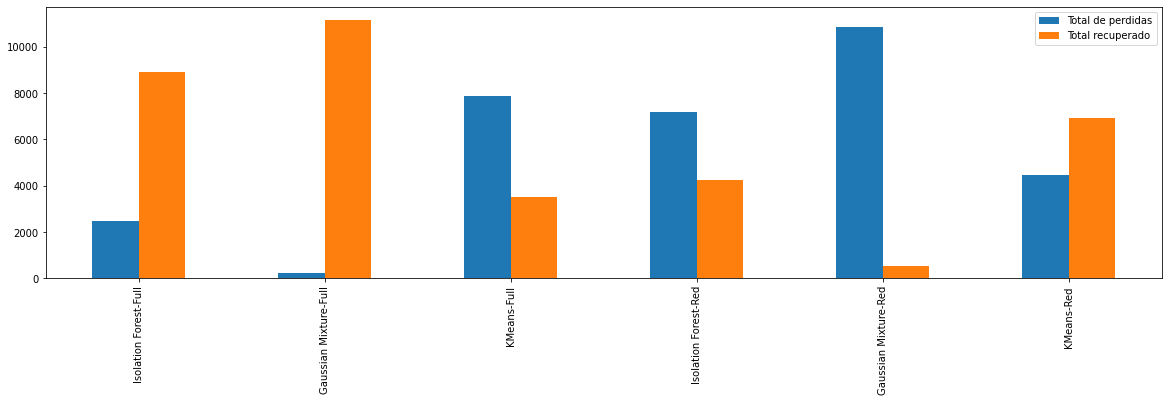

In [ ]:
df_sk.plot(kind='bar',figsize=(20,5))

In [ ]:
def get_performance_curve(fit_data, predict_data, labels, threshold_range, predict_fn, model=None, model_fn=None, model_args=None):
    recall_list = []
    audit_ratio_list = []

    for i in threshold_range:
        if model == None:
            new_model = fit_model(fit_data, model_fn, model_args, i, labels)
        else:
            new_model = model
        
        y_pred = predict_model(predict_data, new_model, predict_fn, i)

        audit_ratio = sum(pred == 1 for pred in y_pred)/len(y_pred)

        recall_list.append(recall_score(labels, y_pred))
        audit_ratio_list.append(audit_ratio)
    
    performance_curve = pd.DataFrame()
    performance_curve['Audit ratio'] = audit_ratio_list
    performance_curve['Detected frauds ratio'] = recall_list

    return performance_curve.sort_values('Audit ratio')

ideal_curve = pd.DataFrame()
ideal_curve['Audit ratio'] = [0, 0.15, 1]
ideal_curve['Detected frauds ratio'] = [0, 1, 1]

def plot_all_performance_curves(
    isolation_forest_full_performance_curve,
    isolation_forest_reduced_performance_curve, 
    gm_full_performance_curve,
    gm_reduced_performance_curve,
    kmeans_full_performance_curve,
    kmeans_reduced_performance_curve,
    title
    ):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(title)
    plt.xlabel('Audit ratio')
    plt.ylabel('Detected frauds ratio')

    plt.xlim(right=0.5)

    x_ticks = np.arange(0, 0.55, 0.05)
    y_ticks = np.arange(0, 1.1, 0.1)

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    # Isolation Forest
    plt.plot(isolation_forest_full_performance_curve['Audit ratio'], isolation_forest_full_performance_curve['Detected frauds ratio'], label='Isolation Forest full')
    plt.plot(isolation_forest_reduced_performance_curve['Audit ratio'], isolation_forest_reduced_performance_curve['Detected frauds ratio'], label='Isolation Forest df reducido')
  
    # Gaussian Mixture
    plt.plot(gm_full_performance_curve['Audit ratio'], gm_full_performance_curve['Detected frauds ratio'], label='Gaussian Mixture full')
    plt.plot(gm_reduced_performance_curve['Audit ratio'], gm_reduced_performance_curve['Detected frauds ratio'], label='Gaussian Mixture df reducido')

    # Kmeans
    plt.plot(kmeans_full_performance_curve['Audit ratio'], kmeans_full_performance_curve['Detected frauds ratio'], label='Kmeans full')
    plt.plot(kmeans_reduced_performance_curve['Audit ratio'], kmeans_reduced_performance_curve['Detected frauds ratio'], label='Kmeans df reducido')

    plt.plot(ideal_curve['Audit ratio'], ideal_curve['Detected frauds ratio'], label='Ideal curve', linestyle='--')
    plt.axvline(0.15, linestyle='--')

    plt.grid(linestyle='--')
    plt.legend()

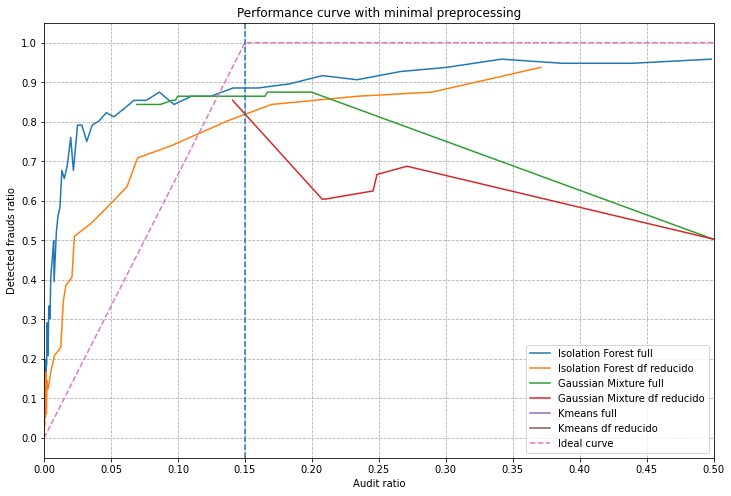

In [ ]:
# Get performance curves with minimal preprocessing
threshold_range = np.logspace(np.log10(0.001), np.log10(0.5))

if_performance_full_curve_test = get_performance_curve(X_train_full, X_test, y_test, threshold_range, predict_isolation_forest, model_fn=fit_isolation_forest)
if_performance_reduced_curve_test = get_performance_curve(X_train_reduced, X_test, y_test, threshold_range, predict_isolation_forest, model_fn=fit_isolation_forest)

gm_full_curve_test = get_performance_curve(X_train_full, X_test, y_test, threshold_range, predict_gaussian_mixture, model_fn=fit_gaussian_mixture)
gm_reduced_curve_test = get_performance_curve(X_train_reduced, X_test, y_test, threshold_range, predict_gaussian_mixture, model_fn=fit_gaussian_mixture)

kmeans_full_curve_test = get_performance_curve(X_train_full, X_test, y_test, threshold_range, predict_isolation_forest, model_fn=fit_kmeans)
kmeans_reduced_curve_test = get_performance_curve(X_train_reduced, X_test, y_test, threshold_range, predict_isolation_forest, model_fn=fit_kmeans)

# Plot performance curves
plot_all_performance_curves(if_performance_full_curve_test, if_performance_reduced_curve_test, gm_full_curve_test, gm_reduced_curve_test, kmeans_full_curve_test, kmeans_reduced_curve_test,'Performance curve with minimal preprocessing')